In [1]:
using PairwiseListMatrices
using Benchmarks
using Base.Test
using Gadfly

In [2]:
# Similar to pairwise of Distances.jl
function using_full(vecs)
  n = length(vecs)
  mat = Array(Float64, n, n)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      mat[i,j] = cor(vec_i, vecs[j])
    end
    for j = 1 : (i-1)
      @inbounds mat[i,j] = mat[j,i]  # leveraging the symmetry
    end
  end
  mat
end

function using_symmetric(vecs)
  n = length(vecs)
  mat = Array(Float64, n, n)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      mat[i,j] = cor(vec_i, vecs[j])
    end
  end
  Symmetric(mat)
end

function using_sparse_symmetric(vecs)
  n = length(vecs)
  mat = spzeros(Float64, n, n)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      mat[i,j] = cor(vec_i, vecs[j])
    end
  end
  Symmetric(mat)
end

# Creates a list and returns it as a PairwiseListMatrix
function using_pairwiselist(vecs)
  n = length(vecs)
  list = Array(Float64, div(n*(n+1),2))
  k = 1
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      list[k] = cor(vec_i, vecs[j])
      k += 1
    end
  end
  PairwiseListMatrix(list, true)
end

# Creates and fill a PairwiseListMatrix
function using_pairwiselistmatrix(vecs)
  n = length(vecs)
  list = PairwiseListMatrix(Float64, n, true)
  @inbounds for i in 1:n
    vec_i = vecs[i]
    for j in i:n
      list[i,j] = cor(vec_i, vecs[j])
    end
  end
  list
end

using_pairwiselistmatrix (generic function with 1 method)

In [3]:
const testset = [ rand(3) for n in 1:500 ];

# Test for the same result
@test all(using_sparse_symmetric(testset) .== using_full(testset))
@test all(using_full(testset) .== using_symmetric(testset))
@test all(using_symmetric(testset) .== using_pairwiselist(testset))
@test all(using_pairwiselist(testset) .== using_pairwiselistmatrix(testset))

@benchmark using_symmetric(testset)

================ Benchmark Results ========================
     Time per evaluation: 35.42 ms [33.60 ms, 37.24 ms]
Proportion of time in GC: 7.37% [5.86%, 8.88%]
        Memory allocated: 28.66 mb
   Number of allocations: 501003 allocations
       Number of samples: 100
   Number of evaluations: 100
 Time spent benchmarking: 3.66 s


In [4]:
@benchmark using_pairwiselist(testset)

================ Benchmark Results ========================
     Time per evaluation: 33.76 ms [31.85 ms, 35.68 ms]
Proportion of time in GC: 8.59% [6.80%, 10.37%]
        Memory allocated: 29.62 mb
   Number of allocations: 625752 allocations
       Number of samples: 100
   Number of evaluations: 100
 Time spent benchmarking: 3.42 s


In [5]:
@benchmark using_pairwiselistmatrix(testset)

================ Benchmark Results ========================
     Time per evaluation: 25.88 ms [24.38 ms, 27.37 ms]
Proportion of time in GC: 9.66% [7.93%, 11.40%]
        Memory allocated: 25.80 mb
   Number of allocations: 375763 allocations
       Number of samples: 100
   Number of evaluations: 100
 Time spent benchmarking: 2.62 s


In [6]:
const SAMPLES = collect(5:50:2000)
const TIME = zeros(Float64, length(SAMPLES)*5)
const NAMES = vcat([ ["full", "symmetric", "sparse", "list", "pairwiselistmatrix"] for i in 1:length(SAMPLES) ]...)
const XS = vcat([ [x, x, x, x, x] for x in SAMPLES ]...)

k = 0
for sample in SAMPLES
    test = [ rand(3) for n in 1:sample ]
    k += 1
    TIME[k] = @elapsed using_full(test)
    k += 1
    TIME[k] = @elapsed using_symmetric(test)
    k += 1
    TIME[k] = sample < 400 ? @elapsed( using_sparse_symmetric(test) ) : NaN
    k += 1
    TIME[k] = @elapsed using_pairwiselist(test)
    k += 1
    TIME[k] = @elapsed using_pairwiselistmatrix(test)
end

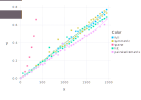

In [7]:
plot(x=XS, y=TIME, color=NAMES, Geom.point, Geom.smooth, Scale.y_sqrt)